In [1]:
'''in this version we always use the same batch of images'''

'in this version we always use the same batch of images'

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent
from rl_networks import create_actor_network_test_v1

from test_envs import SimpleCartPole_v2 

import types
config = types.SimpleNamespace()
config.batch_size = 1
# config.margin = 20
# config.image_h = 224
# config.image_w = 224
# config.image_hm = config.image_h+2*config.margin
# config.image_wm = config.image_w+2*config.margin
# config.foveate = None
# config.do_grayscale = True
# config.history_length = 16
# config.t_ignore = 16
# config.t_max =50
# config.motion_mode = 'velocity'
# config.use_dones = False

# config.gym_mode = False
# t_vec = np.linspace(0,150,16)

# balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
# config.filter = balanced_filter.reshape([1,1,-1,1])
# config.min_freq = 1
# config.max_freq = 13
# config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

# dataset = get_dataset(dataset_dir,
#                                      'validation',
#                                      config.batch_size,
#                                      image_h = config.image_hm,
#                                      image_w = config.image_wm,
#                                      preprocessing='identity',
#                                      rggb_mode=False,
#                                      central_squeeze_and_pad_factor=-1)

# # env = RetinaEnv(config, image_generator=dataset)
# env = RetinaEnv(config) #freezing on first batch
# for images,_ in dataset:
#     break
    
env =  SimpleCartPole_v2()




# actor_model = create_actor_model(env.image_h, env.image_w,
#                                  env.spectral_density_size, env.location_history_size,
#                                  env.timestep_size, env.action_size)
actor_model = create_actor_network_test_v1((4,), 2.0)

actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=0.3,model=actor_model,action_dim=1)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:
#         print('kuka')
#         %time \
        deterministic_action, means,stdevs = agent.get_action(prev_state[np.newaxis,...],return_stats=True)
#         print('kukaend')
        action = deterministic_action #hook in order to add noise if neccessary
#         state, reward, done, info = env.step(np.reshape(action,[1]))
#         print('kuka2')
#         %time\
        state, reward, done, info = env.step(action[0][0])
#         print('kukaend2')

#         if env.warmup_done:
        states.append([prev_state])
        actions.append(action)
        rewards.append(reward)

        episodic_reward += reward

        action_mean_records.append(deterministic_action.mean(axis=0))
        action_var_records.append(deterministic_action.var(axis=0))
        action_statmean_records.append(means)
        action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
#     print('kuka3')
    agent.train(np.array(states), np.array(actions), np.array(rewards))
#     print('kukaend3')

    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {np.mean([episodic_reward])}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Episode * 0 * Episodic Reward is ==> 59.99300700498931
action means and variances at step -10: [-0.4627992] [0.]
action means and variances at step -5: [-0.09203294] [0.]
action statmeans and variances at step -10: [0.00811826] [0.3]
action statmeans and variances at step -5: [0.01357205] [0.3]
Episode * 1 * Episodic Reward is ==> 115.97189788005146
action means and variances at step -10: [-0.24986345] [0.]
action means and variances at step -5: [-0.1376177] [0.]
action statmeans and variances at step -10: [-0.00881906] [0.3]
action statmeans and variances at step -5: [-0.00098384] [0.3]
Episode * 2 * Episodic Reward is ==> 131.96903575311262
action means and variances at step -10: [0.51879379] [0.]
action means and variances at step -5: [0.07723557] [0.]
action statmeans and variances at step -10: [0.01740887] [0.3]
action statmeans and variances at step -5: [0.02271396] [0.3]
Episode * 3 * Episodic Reward is ==> 49.9876799680552
action means and variances at step -10: [-0.50862975] [

Episode * 28 * Episodic Reward is ==> 52.98794835556754
action means and variances at step -10: [-0.41315591] [0.]
action means and variances at step -5: [0.23483146] [0.]
action statmeans and variances at step -10: [0.02657435] [0.3]
action statmeans and variances at step -5: [0.03775577] [0.3]
Episode * 29 * Episodic Reward is ==> 49.987787345142394
action means and variances at step -10: [0.30342367] [0.]
action means and variances at step -5: [-0.1748924] [0.]
action statmeans and variances at step -10: [0.03336896] [0.3]
action statmeans and variances at step -5: [0.04155945] [0.3]
Episode * 30 * Episodic Reward is ==> 60.98966617693254
action means and variances at step -10: [-0.00787392] [0.]
action means and variances at step -5: [0.28566445] [0.]
action statmeans and variances at step -10: [0.02355259] [0.3]
action statmeans and variances at step -5: [0.02927666] [0.3]
Episode * 31 * Episodic Reward is ==> 58.98987718543215
action means and variances at step -10: [0.18723975] 

Episode * 56 * Episodic Reward is ==> 98.99500746760785
action means and variances at step -10: [0.59773295] [0.]
action means and variances at step -5: [-0.02955914] [0.]
action statmeans and variances at step -10: [0.01743583] [0.3]
action statmeans and variances at step -5: [0.0245343] [0.3]
Episode * 57 * Episodic Reward is ==> 59.991550704601565
action means and variances at step -10: [-0.12076155] [0.]
action means and variances at step -5: [-0.49340031] [0.]
action statmeans and variances at step -10: [-0.11030532] [0.3]
action statmeans and variances at step -5: [-0.188077] [0.3]
Episode * 58 * Episodic Reward is ==> 84.98829472647081
action means and variances at step -10: [-0.01141974] [0.]
action means and variances at step -5: [-0.05027775] [0.]
action statmeans and variances at step -10: [0.02674642] [0.3]
action statmeans and variances at step -5: [0.03714406] [0.3]
Episode * 59 * Episodic Reward is ==> 65.99002836954948
action means and variances at step -10: [-0.1584436

Episode * 84 * Episodic Reward is ==> 60.988687364010474
action means and variances at step -10: [0.12562553] [0.]
action means and variances at step -5: [-0.15731745] [0.]
action statmeans and variances at step -10: [0.02714233] [0.3]
action statmeans and variances at step -5: [0.03531564] [0.3]
Episode * 85 * Episodic Reward is ==> 78.99527741398414
action means and variances at step -10: [0.28651018] [0.]
action means and variances at step -5: [-0.1403603] [0.]
action statmeans and variances at step -10: [-0.14909144] [0.3]
action statmeans and variances at step -5: [-0.23904449] [0.3]
Episode * 86 * Episodic Reward is ==> 60.98963381808144
action means and variances at step -10: [-0.22286622] [0.]
action means and variances at step -5: [0.06125748] [0.]
action statmeans and variances at step -10: [0.02284271] [0.3]
action statmeans and variances at step -5: [0.03215967] [0.3]
Episode * 87 * Episodic Reward is ==> 59.99170396392967
action means and variances at step -10: [-0.0388390

Episode * 112 * Episodic Reward is ==> 70.99323705269721
action means and variances at step -10: [-0.66763684] [0.]
action means and variances at step -5: [0.3215702] [0.]
action statmeans and variances at step -10: [-0.16819671] [0.3]
action statmeans and variances at step -5: [-0.21467954] [0.3]
Episode * 113 * Episodic Reward is ==> 80.9929257641169
action means and variances at step -10: [-0.10700136] [0.]
action means and variances at step -5: [-0.53832514] [0.]
action statmeans and variances at step -10: [0.01474828] [0.3]
action statmeans and variances at step -5: [0.0229388] [0.3]
Episode * 114 * Episodic Reward is ==> 57.98915657163867
action means and variances at step -10: [0.25863605] [0.]
action means and variances at step -5: [-0.18765076] [0.]
action statmeans and variances at step -10: [0.03139683] [0.3]
action statmeans and variances at step -5: [0.04272178] [0.3]
Episode * 115 * Episodic Reward is ==> 82.99256622381006
action means and variances at step -10: [0.224567

Episode * 140 * Episodic Reward is ==> 64.99112592710607
action means and variances at step -10: [-0.31599548] [0.]
action means and variances at step -5: [-0.1724378] [0.]
action statmeans and variances at step -10: [-0.1717819] [0.3]
action statmeans and variances at step -5: [-0.21091987] [0.3]
Episode * 141 * Episodic Reward is ==> 58.99093408263998
action means and variances at step -10: [-0.13884428] [0.]
action means and variances at step -5: [-0.20049242] [0.]
action statmeans and variances at step -10: [0.02843012] [0.3]
action statmeans and variances at step -5: [0.03774613] [0.3]
Episode * 142 * Episodic Reward is ==> 76.99514093016128
action means and variances at step -10: [0.18721997] [0.]
action means and variances at step -5: [0.01719634] [0.]
action statmeans and variances at step -10: [0.02267046] [0.3]
action statmeans and variances at step -5: [0.03162507] [0.3]
Episode * 143 * Episodic Reward is ==> 88.99514623636648
action means and variances at step -10: [-0.0158

Episode * 168 * Episodic Reward is ==> 69.98943687432254
action means and variances at step -10: [0.05930418] [0.]
action means and variances at step -5: [-0.680431] [0.]
action statmeans and variances at step -10: [-0.17177634] [0.3]
action statmeans and variances at step -5: [-0.22971523] [0.3]
Episode * 169 * Episodic Reward is ==> 61.98905154997857
action means and variances at step -10: [-0.22433171] [0.]
action means and variances at step -5: [-0.02609437] [0.]
action statmeans and variances at step -10: [-0.18749976] [0.3]
action statmeans and variances at step -5: [-0.24142113] [0.3]
Episode * 170 * Episodic Reward is ==> 60.987687832382576
action means and variances at step -10: [-0.09321108] [0.]
action means and variances at step -5: [-0.48594883] [0.]
action statmeans and variances at step -10: [-0.19609693] [0.3]
action statmeans and variances at step -5: [-0.23940645] [0.3]
Episode * 171 * Episodic Reward is ==> 67.99167971072376
action means and variances at step -10: [-

Episode * 196 * Episodic Reward is ==> 99.98295617118202
action means and variances at step -10: [-0.51518027] [0.]
action means and variances at step -5: [-0.87062562] [0.]
action statmeans and variances at step -10: [-0.19335681] [0.3]
action statmeans and variances at step -5: [-0.23979616] [0.3]
Episode * 197 * Episodic Reward is ==> 72.98953723431
action means and variances at step -10: [-0.00987804] [0.]
action means and variances at step -5: [0.43043938] [0.]
action statmeans and variances at step -10: [-0.17048982] [0.3]
action statmeans and variances at step -5: [-0.25307643] [0.3]
Episode * 198 * Episodic Reward is ==> 54.989742020515045
action means and variances at step -10: [-0.19230625] [0.]
action means and variances at step -5: [0.00819081] [0.]
action statmeans and variances at step -10: [0.02930317] [0.3]
action statmeans and variances at step -5: [0.036998] [0.3]
Episode * 199 * Episodic Reward is ==> 65.99416112192998
action means and variances at step -10: [-0.2930

Episode * 224 * Episodic Reward is ==> 63.99227994372371
action means and variances at step -10: [0.22786218] [0.]
action means and variances at step -5: [-0.13291732] [0.]
action statmeans and variances at step -10: [0.03159384] [0.3]
action statmeans and variances at step -5: [0.04240688] [0.3]
Episode * 225 * Episodic Reward is ==> 59.99067563606456
action means and variances at step -10: [-0.13516135] [0.]
action means and variances at step -5: [0.41907608] [0.]
action statmeans and variances at step -10: [0.03445708] [0.3]
action statmeans and variances at step -5: [0.04408484] [0.3]
Episode * 226 * Episodic Reward is ==> 51.98973942763596
action means and variances at step -10: [0.11655086] [0.]
action means and variances at step -5: [-0.08861145] [0.]
action statmeans and variances at step -10: [0.02737764] [0.3]
action statmeans and variances at step -5: [0.03717579] [0.3]
Episode * 227 * Episodic Reward is ==> 60.99306598595885
action means and variances at step -10: [0.409987

Episode * 252 * Episodic Reward is ==> 62.99325212973685
action means and variances at step -10: [-0.10345118] [0.]
action means and variances at step -5: [-0.41530676] [0.]
action statmeans and variances at step -10: [-0.1810181] [0.3]
action statmeans and variances at step -5: [-0.25740084] [0.3]
Episode * 253 * Episodic Reward is ==> 55.98932761343017
action means and variances at step -10: [0.42614702] [0.]
action means and variances at step -5: [0.13960113] [0.]
action statmeans and variances at step -10: [0.03822126] [0.3]
action statmeans and variances at step -5: [0.04838425] [0.3]
Episode * 254 * Episodic Reward is ==> 78.9933523129013
action means and variances at step -10: [-0.26336716] [0.]
action means and variances at step -5: [0.33203439] [0.]
action statmeans and variances at step -10: [0.02886748] [0.3]
action statmeans and variances at step -5: [0.04130426] [0.3]
Episode * 255 * Episodic Reward is ==> 84.98542960997166
action means and variances at step -10: [-0.03274

Episode * 280 * Episodic Reward is ==> 53.99070606182793
action means and variances at step -10: [-0.18933532] [0.]
action means and variances at step -5: [0.16856122] [0.]
action statmeans and variances at step -10: [0.02429658] [0.3]
action statmeans and variances at step -5: [0.03362096] [0.3]
Episode * 281 * Episodic Reward is ==> 64.98961451673662
action means and variances at step -10: [-0.04345425] [0.]
action means and variances at step -5: [-0.08344014] [0.]
action statmeans and variances at step -10: [0.03634918] [0.3]
action statmeans and variances at step -5: [0.05499429] [0.3]
Episode * 282 * Episodic Reward is ==> 69.99460798786626
action means and variances at step -10: [-0.31810327] [0.]
action means and variances at step -5: [0.33115146] [0.]
action statmeans and variances at step -10: [-0.21640155] [0.3]
action statmeans and variances at step -5: [-0.26442608] [0.3]
Episode * 283 * Episodic Reward is ==> 92.99268732624456
action means and variances at step -10: [-0.23

Episode * 308 * Episodic Reward is ==> 81.99304143463507
action means and variances at step -10: [-0.36718543] [0.]
action means and variances at step -5: [0.05318142] [0.]
action statmeans and variances at step -10: [0.01823366] [0.3]
action statmeans and variances at step -5: [0.0308348] [0.3]
Episode * 309 * Episodic Reward is ==> 41.98589776478957
action means and variances at step -10: [-0.11522946] [0.]
action means and variances at step -5: [0.53753916] [0.]
action statmeans and variances at step -10: [0.04113179] [0.3]
action statmeans and variances at step -5: [0.05346701] [0.3]
Episode * 310 * Episodic Reward is ==> 85.99051022521074
action means and variances at step -10: [-0.04537424] [0.]
action means and variances at step -5: [-0.04617525] [0.]
action statmeans and variances at step -10: [-0.19494444] [0.3]
action statmeans and variances at step -5: [-0.25704083] [0.3]
Episode * 311 * Episodic Reward is ==> 64.98813140075568
action means and variances at step -10: [-0.005

Episode * 336 * Episodic Reward is ==> 62.98956391011103
action means and variances at step -10: [-0.16922769] [0.]
action means and variances at step -5: [-0.20080594] [0.]
action statmeans and variances at step -10: [0.03392122] [0.3]
action statmeans and variances at step -5: [0.04477] [0.3]
Episode * 337 * Episodic Reward is ==> 67.99305785014452
action means and variances at step -10: [0.36875285] [0.]
action means and variances at step -5: [0.21717815] [0.]
action statmeans and variances at step -10: [0.02899672] [0.3]
action statmeans and variances at step -5: [0.03937253] [0.3]
Episode * 338 * Episodic Reward is ==> 60.990898160596934
action means and variances at step -10: [0.50761845] [0.]
action means and variances at step -5: [0.36061454] [0.]
action statmeans and variances at step -10: [0.02608703] [0.3]
action statmeans and variances at step -5: [0.0359341] [0.3]
Episode * 339 * Episodic Reward is ==> 89.97507983832634
action means and variances at step -10: [-0.28283357]

Episode * 364 * Episodic Reward is ==> 57.98874299691949
action means and variances at step -10: [-0.23496396] [0.]
action means and variances at step -5: [0.11322469] [0.]
action statmeans and variances at step -10: [0.03855072] [0.3]
action statmeans and variances at step -5: [0.05155498] [0.3]
Episode * 365 * Episodic Reward is ==> 63.991271525404606
action means and variances at step -10: [-0.30001167] [0.]
action means and variances at step -5: [-0.30036912] [0.]
action statmeans and variances at step -10: [0.03131462] [0.3]
action statmeans and variances at step -5: [0.04477538] [0.3]
Episode * 366 * Episodic Reward is ==> 81.98059860072023
action means and variances at step -10: [-0.02550289] [0.]
action means and variances at step -5: [-0.84582673] [0.]
action statmeans and variances at step -10: [-0.20641553] [0.3]
action statmeans and variances at step -5: [-0.3145017] [0.3]
Episode * 367 * Episodic Reward is ==> 70.99138623534945
action means and variances at step -10: [-0.3

Episode * 392 * Episodic Reward is ==> 76.99472155492661
action means and variances at step -10: [0.2804218] [0.]
action means and variances at step -5: [-0.08259679] [0.]
action statmeans and variances at step -10: [0.03064402] [0.3]
action statmeans and variances at step -5: [0.04070041] [0.3]
Episode * 393 * Episodic Reward is ==> 118.99269344352466
action means and variances at step -10: [-0.26287115] [0.]
action means and variances at step -5: [0.01275427] [0.]
action statmeans and variances at step -10: [0.02939595] [0.3]
action statmeans and variances at step -5: [0.04382202] [0.3]
Episode * 394 * Episodic Reward is ==> 81.99204470297032
action means and variances at step -10: [-0.34355945] [0.]
action means and variances at step -5: [-0.05647681] [0.]
action statmeans and variances at step -10: [-0.17753455] [0.3]
action statmeans and variances at step -5: [-0.26875827] [0.3]
Episode * 395 * Episodic Reward is ==> 57.989645159393305
action means and variances at step -10: [0.21

Episode * 420 * Episodic Reward is ==> 79.99016558841552
action means and variances at step -10: [0.49364665] [0.]
action means and variances at step -5: [0.18796561] [0.]
action statmeans and variances at step -10: [-0.20835155] [0.3]
action statmeans and variances at step -5: [-0.3017334] [0.3]
Episode * 421 * Episodic Reward is ==> 65.99357664541003
action means and variances at step -10: [-0.00645843] [0.]
action means and variances at step -5: [-0.47087508] [0.]
action statmeans and variances at step -10: [-0.19800745] [0.3]
action statmeans and variances at step -5: [-0.28221458] [0.3]
Episode * 422 * Episodic Reward is ==> 59.99211146471466
action means and variances at step -10: [-0.28840681] [0.]
action means and variances at step -5: [-0.40172699] [0.]
action statmeans and variances at step -10: [-0.23049335] [0.3]
action statmeans and variances at step -5: [-0.3122614] [0.3]
Episode * 423 * Episodic Reward is ==> 83.99357049040425
action means and variances at step -10: [-0.

Episode * 448 * Episodic Reward is ==> 89.98104174359476
action means and variances at step -10: [0.03229522] [0.]
action means and variances at step -5: [0.07175365] [0.]
action statmeans and variances at step -10: [0.04633237] [0.3]
action statmeans and variances at step -5: [0.05880468] [0.3]
Episode * 449 * Episodic Reward is ==> 52.99008067163058
action means and variances at step -10: [-0.28549424] [0.]
action means and variances at step -5: [-0.75939383] [0.]
action statmeans and variances at step -10: [-0.19938935] [0.3]
action statmeans and variances at step -5: [-0.27447495] [0.3]
Episode * 450 * Episodic Reward is ==> 83.9858239017732
action means and variances at step -10: [-0.30401283] [0.]
action means and variances at step -5: [-0.20221738] [0.]
action statmeans and variances at step -10: [0.05165409] [0.3]
action statmeans and variances at step -5: [0.0650539] [0.3]
Episode * 451 * Episodic Reward is ==> 96.99243052065812
action means and variances at step -10: [-0.0088

Episode * 476 * Episodic Reward is ==> 71.99021286186591
action means and variances at step -10: [0.41319294] [0.]
action means and variances at step -5: [0.29354561] [0.]
action statmeans and variances at step -10: [0.04599615] [0.3]
action statmeans and variances at step -5: [0.05813276] [0.3]
Episode * 477 * Episodic Reward is ==> 91.99402341254249
action means and variances at step -10: [-0.27523684] [0.]
action means and variances at step -5: [0.31999267] [0.]
action statmeans and variances at step -10: [0.03558795] [0.3]
action statmeans and variances at step -5: [0.04653143] [0.3]
Episode * 478 * Episodic Reward is ==> 73.99271877459496
action means and variances at step -10: [-0.20906448] [0.]
action means and variances at step -5: [-0.79884625] [0.]
action statmeans and variances at step -10: [-0.20184425] [0.3]
action statmeans and variances at step -5: [-0.29679197] [0.3]
Episode * 479 * Episodic Reward is ==> 64.99168380944502
action means and variances at step -10: [-0.183

Episode * 504 * Episodic Reward is ==> 49.988475886592184
action means and variances at step -10: [-0.20571626] [0.]
action means and variances at step -5: [0.06721267] [0.]
action statmeans and variances at step -10: [0.05356453] [0.3]
action statmeans and variances at step -5: [0.07330997] [0.3]
Episode * 505 * Episodic Reward is ==> 60.98932142658899
action means and variances at step -10: [-0.58897516] [0.]
action means and variances at step -5: [-0.96901042] [0.]
action statmeans and variances at step -10: [-0.2152334] [0.3]
action statmeans and variances at step -5: [-0.2932986] [0.3]
Episode * 506 * Episodic Reward is ==> 98.99055616015544
action means and variances at step -10: [-0.02440102] [0.]
action means and variances at step -5: [0.34274888] [0.]
action statmeans and variances at step -10: [0.03497462] [0.3]
action statmeans and variances at step -5: [0.04512092] [0.3]
Episode * 507 * Episodic Reward is ==> 57.98982191801046
action means and variances at step -10: [0.1590

Episode * 532 * Episodic Reward is ==> 57.9892878691826
action means and variances at step -10: [0.34741152] [0.]
action means and variances at step -5: [-0.3183957] [0.]
action statmeans and variances at step -10: [0.04667884] [0.3]
action statmeans and variances at step -5: [0.05728434] [0.3]
Episode * 533 * Episodic Reward is ==> 49.987995781617414
action means and variances at step -10: [-0.02160168] [0.]
action means and variances at step -5: [0.04946018] [0.]
action statmeans and variances at step -10: [0.05481305] [0.3]
action statmeans and variances at step -5: [0.07180893] [0.3]
Episode * 534 * Episodic Reward is ==> 62.990339430314926
action means and variances at step -10: [-0.04016384] [0.]
action means and variances at step -5: [-0.28903571] [0.]
action statmeans and variances at step -10: [0.04816594] [0.3]
action statmeans and variances at step -5: [0.06206485] [0.3]
Episode * 535 * Episodic Reward is ==> 88.99361980968452
action means and variances at step -10: [-0.6977

Episode * 560 * Episodic Reward is ==> 64.99482311241859
action means and variances at step -10: [0.24448015] [0.]
action means and variances at step -5: [0.05598803] [0.]
action statmeans and variances at step -10: [-0.22120534] [0.3]
action statmeans and variances at step -5: [-0.29731026] [0.3]
Episode * 561 * Episodic Reward is ==> 84.99031055530179
action means and variances at step -10: [0.23429832] [0.]
action means and variances at step -5: [-0.02590067] [0.]
action statmeans and variances at step -10: [0.04547287] [0.3]
action statmeans and variances at step -5: [0.05956233] [0.3]
Episode * 562 * Episodic Reward is ==> 72.99104813930555
action means and variances at step -10: [-0.5457444] [0.]
action means and variances at step -5: [-0.21306807] [0.]
action statmeans and variances at step -10: [-0.17155275] [0.3]
action statmeans and variances at step -5: [-0.26437864] [0.3]
Episode * 563 * Episodic Reward is ==> 163.98329987762065
action means and variances at step -10: [-0.2

Episode * 588 * Episodic Reward is ==> 64.99296008194746
action means and variances at step -10: [0.10168385] [0.]
action means and variances at step -5: [0.35607929] [0.]
action statmeans and variances at step -10: [0.04481022] [0.3]
action statmeans and variances at step -5: [0.06176024] [0.3]
Episode * 589 * Episodic Reward is ==> 56.98970298231847
action means and variances at step -10: [-0.17297494] [0.]
action means and variances at step -5: [-0.26216601] [0.]
action statmeans and variances at step -10: [-0.21174704] [0.3]
action statmeans and variances at step -5: [-0.26687017] [0.3]
Episode * 590 * Episodic Reward is ==> 69.99102403448914
action means and variances at step -10: [-0.70697931] [0.]
action means and variances at step -5: [-0.01971306] [0.]
action statmeans and variances at step -10: [-0.20037846] [0.3]
action statmeans and variances at step -5: [-0.27510947] [0.3]
Episode * 591 * Episodic Reward is ==> 57.989138372900534
action means and variances at step -10: [0.

KeyboardInterrupt: 

In [4]:
plt.plot(reward_records_)

NameError: name 'reward_records_' is not defined

In [ ]:
plt.plot(rewards)

In [5]:
import misc

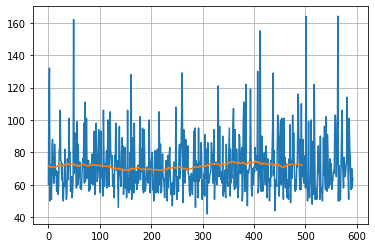

In [8]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


In [ ]:
# plt.plot(reward_records)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()
plt.ylim([-15,-5])

In [ ]:
plt.plot(buffer.critic_loss_buffer[100:])
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))

In [ ]:
np.shape(action_statmean_records)

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

In [ ]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

In [ ]:
action_statmean_records[-300:]